In [1]:
import os
import math as m
from codes_gendrops_py.genSingleDrop import *
from codes_gendrops_py.fit_circle_through_3_points import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pre_process_functions import *
from PIL import Image
import numpy as np

## Definite the pre processing functions

In [2]:
def remove_needle_centering(img_ori,savepath='./images_notupload'):
    '''img_ori=Image.open(path_ori)'''
    w_ori,h_ori=img_ori.size

    scaling_ori=300/w_ori # reshape the origin image to width 300

    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))

    left_edge=np.zeros(w_ori2)
    right_edge=np.zeros(w_ori2)
    for i in range(h_ori2):
        for j in range(w_ori2):
            if A[i,j-1]>=125 and A[i,j]<125:
                #print('Left position',i,j)
                left_edge[i]=j
            if A[i,j-1]<=125 and A[i,j]>125:
                #print('Right position',i,j)
                right_edge[i]=j

    needle=np.abs(left_edge-right_edge)

    end=0
    for j in range(needle.shape[0]-1):
        j=j+1
        if end == 0:
            if abs((needle[j]-needle[0])/needle[0])>0.05:
                stopline=j
                end=end+1
    #print(stopline)

    addpad=right_edge[stopline]-needle[stopline]/2-w_ori2/2

    img_WON=np.zeros((h_ori2-stopline,w_ori2))
    for i in range(h_ori2):
        if i>=stopline:
            img_WON[i-stopline,:]=A[i,:]
    
    h_won,w_won=img_WON.shape
    
    # centering
    if addpad>0:
        img_won=np.hstack( ( img_WON,np.ones((h_won,abs(int(addpad*4))))*255 ) )
    elif addpad<0:
        img_won=np.hstack( ( np.ones((h_won,abs(int(addpad*4))))*255,img_WON ) )
    else:
        img_won=img_WON

    img=Image.fromarray(np.uint8(img_won))

    path=savepath+"/cut_needle_pixel_rn%.2f.png" %(needle[0])
    img.save(path)
    return path,needle


In [3]:
def gen_doplet_v3(sigma,volume0,rneedle=0.5,savepath='./images_notupload',output=1):
    r_a,z_a=genSingleDrop(sigma=sigma,volume0=volume0,savepath=savepath,rneedle=rneedle,output=output)

    path=savepath+"/s%.2f_v%.2f_rn1_wmax_%.2f.jpg" %(sigma, volume0, 2*max(abs(r_a)))

    plt.fill_between(r_a,z_a,color='black')
    plt.fill_between(-r_a,z_a,color='black')
    plt.axis('equal')
    plt.axis('off')
    plt.savefig(path)
    plt.close()

    wmax=2*max(abs(r_a))
    return path,wmax,rneedle

In [4]:
def resize_synimg(img_syn,wmax,r_pixel_ori,r_syn=1):
    '''img_ori=Image.open(path_ori)'''
    w,h=img_syn.size
    w_n=wmax/(2*r_syn)*50
    scaling=w_n/w
    h_n=scaling*h
    new_syn=ResizeImage(img_syn,int(w_n),int(h_n))
    return new_syn

In [5]:
def cost_v3(img_ori,img_syn,width=100,output=0):
    '''
    input:              
    x:                the origin point of synthetic image
    img_syn,img_ori:    the images that need to calculate the cost 
                        should be valued by 'Image.open(path)'
    K:                  the scaling of synthethic image
    output: 0 -->lost, 1-->C, else C,lost
    '''
    w_ori,h_ori=img_ori.size
    w_syn,h_syn=img_syn.size
    

    scaling_ori=width/w_ori # reshape the origin image to width
    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)
    scaling_syn=scaling_ori
    w_syn2=int(scaling_syn*w_syn)
    h_syn2=int(scaling_syn*h_syn)
    x=int(abs((w_syn2-w_ori2)/2))

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))
    one=np.ones((w_ori2-h_ori2,w_ori2))*255
    A=np.row_stack((A,one))


    B=img2bw(ResizeImage(img_syn,w_syn2,h_syn2))
    C=np.zeros((w_ori2,w_ori2))

    for i in range (w_ori2): # h
        for j in range(w_ori2): # w
            #print (h_ori2,w_ori2)
            #print(i,j)
            if j < x or j-x >= w_syn2 or i >= h_syn2 :
                 C[i,j]=A[i,j]
            else:
                if  A[i,j]==B[i,j-x]: # B[i-y,j-x]
                    C[i,j]=255
                else:
                    C[i,j]=0
    
    # pixel that same(T) different(F) and drop area
    t=0; f=0; 
    #drop_ori=0; drop_gen=0 
    for i in range (w_ori2):
        for j in range(h_ori2):
            if C[i,j]==0:
                f=f+1
            else:
                t=t+1
    lost=f/max(w_ori2*h_ori2,w_syn2*h_syn2)
    accurancy=1-lost

    if output == 0:
        return lost
    elif output == 1:
        return C
    else:
        return C,lost

## Test the cost (Can be passed)

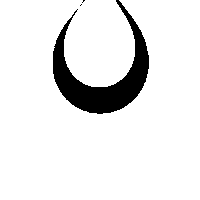

In [6]:
sigma=100
volume0=30
# pre prosessing the ori image
path_ori='./images_experiment/220304_miliq_T17.7_S73.04.png'
path_ori,needle=remove_needle_centering(Image.open(path_ori))
img_ori=Image.open(path_ori)
pixel_needle=needle[0]

# gen and post prosessing the syn image
path_img='./images_notupload/'
# generate the syn image
path_syn,wmax,rneedle=gen_doplet_v3(sigma=sigma,volume0=volume0,rneedle=0.8)

# cut the white edge of syn image
_,path_syn = crop_margin(io.imread(path_syn))

# reshape the syn image to make sure the pixel of rneedle is equal to ori image
img_syn=resize_synimg(Image.open(path_syn),wmax,r_pixel_ori=pixel_needle,r_syn=1)

C,cost=cost_v3(img_ori,img_syn,output=2,width=200)
Image.fromarray(np.uint8(C))


## Definite the obtimize funciton

In [9]:
def obtimize_v3(sv,path_ori=os.path.abspath('./images_experiment/220304_miliq_T17.7_S73.04.png'),output=0):
    sigma=sv[0]
    v0=sv[1]

    # pre prosessing the ori image
    path_ori,needle=remove_needle_centering(Image.open(path_ori))
    img_ori=Image.open(path_ori)
    pixel_needle=needle[0]

    # gen and post prosessing the syn image
    path_img='./images_notupload/'
    # generate the syn image
    path_syn,wmax,rneedle=gen_doplet_v3(sigma=sigma,volume0=v0)

    # cut the white edge of syn image
    _,path_syn = crop_margin(io.imread(path_syn))
    img_syn=resize_synimg(Image.open(path_syn),wmax,r_pixel_ori=pixel_needle,r_syn=1)
    if output==0:
        lost=cost_v3(img_ori,img_syn,output=output)
        return lost
    elif output==1:
        C=cost_v3(img_ori,img_syn,output=output)
        return C
    else :
        C,lost=cost_v3(img_ori,img_syn,output=output)
        return C, lost

## Start the optimization

In [15]:
import scipy.optimize
# use scipy obtimaize the parameter
x0=np.asarray((75,11))
#sigma; v0; length_Ne,r_Ne; x,y; scaling_rate;
scipy.optimize.minimize(obtimize_v3,x0,method='nelder-mead')

MemoryError: 

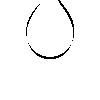

In [13]:
x=np.asarray((73,16))
C,lost=obtimize_v3(sv=x,output=2)
Image.fromarray(np.uint8(C))
